In [14]:
# To generate maps in flat-sky approximation we need NaMaster (pymaster)
# To install pymaster -> conda install namaster -c conda-forge
import pymaster as nmt
import healpy
# If you prefer to work on spherical geometry you can use HEALPix/healpy -> conda install healpy -c conda-forge or pip install healpy
#Important! If you are using this in a notebook, import pymaster *before* any matplotlib/numpy to avoid OpenMP conflicts

In [15]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [56]:
cls = np.loadtxt("planck_2018_cl/base_plikHM_TTTEEE_lowl_lowE_lensing_scalCls.dat")
# Generate an artificial power-spectrum (you can use a "realistic" power-spectrum from CAMB or CLASS)
ells_input = np.arange(1,10000) # We generate 10,000 multipoles
cl_input = cls[:,4] # Simple power-law power-spectrum

In [57]:
#We are going to generate flatmaps using the Flatmap class
import flatmaps as fm
from astropy.wcs import WCS

In [58]:
# Create the empty map object with the resolution that we want
reso = 2./60 # 2 arcmin resolution maps
side = 10 # 10 degree side
# Generate the WCS (world coordinate system) for the flatmap
w = WCS(naxis=2)
nx = int(side/reso) #Number of pixels in the x axis
ny = int(side/reso) #Number of pixels in the y axis
w.wcs.crpix = [nx/2, ny/2] # Center pixel X, Y
w.wcs.cdelt = np.array([-reso, reso])
w.wcs.crval = [0, 0] # Center coordinates RA, DEC at 0,0
w.wcs.ctype = ["RA---TAN", "DEC--TAN"] # Gnomonic projection
fmi = fm.FlatMapInfo(w, nx=nx, ny=ny, lx=side, ly=side) # This is the map object that will be used to generate the fake CMB maps

In [59]:
map_gen = nmt.synfast_flat(int(fmi.nx),int(fmi.ny),fmi.lx_rad,fmi.ly_rad,
                              [cl_input],[0])

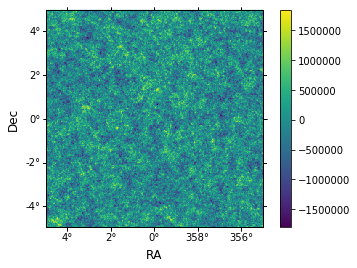

In [60]:
fmi.view_map(map_gen[0].flatten()) # Check the map with the FlatMapInfo class' visualization tool

In [61]:
mask = np.ones_like(map_gen[0]) # Generate a mask

In [62]:
#Now, time to compute the power-spectrum!
ff0=nmt.NmtFieldFlat(fmi.lx_rad,fmi.ly_rad,mask.reshape([fmi.ny,fmi.nx]), 
                                 [map_gen[0].reshape([fmi.ny,fmi.nx])]) # Create a namaster field object

In [63]:
#Initialize the workspace
w00=nmt.NmtWorkspaceFlat();

In [64]:
#Establish the binning
ell_min=max(2*np.pi/fmi.lx_rad,2*np.pi/fmi.ly_rad)
ell_max=min(fmi.nx*np.pi/fmi.lx_rad,fmi.ny*np.pi/fmi.ly_rad)
d_ell=2*ell_min
n_ell=int((ell_max-ell_min)/d_ell)-1
l_bpw=np.zeros([2,n_ell])
l_bpw[0,:]=ell_min+np.arange(n_ell)*d_ell
l_bpw[1,:]=l_bpw[0,:]+d_ell
b=nmt.NmtBinFlat(l_bpw[0,:],l_bpw[1,:])

In [65]:
# Compute power-spectrum!!
cl_00 = nmt.compute_full_master_flat(ff0, ff0, b)

Text(0,0.5,'$C_{\\ell}$')

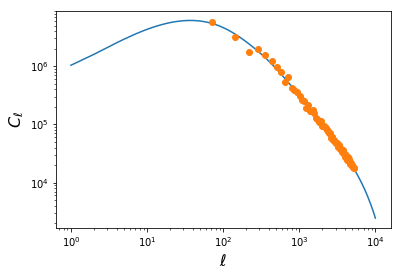

In [66]:
# Check our results!
plt.loglog(ells_input, cl_input, '-', label='Input')
plt.loglog(b.get_effective_ells(), cl_00[0], 'o', label='Output')
plt.xlabel(r'$\ell$', fontsize=16)
plt.ylabel(r'$C_{\ell}$', fontsize=16)
#Success (hopefully)!!

In [67]:
fft2D = np.fft.fft2(map_gen[0])

Text(0.5,1,'Real')

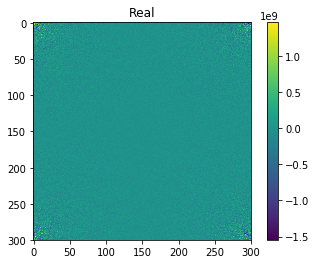

In [68]:
plt.imshow(np.real(fft2D))
plt.colorbar()
plt.title("Real")

Text(0.5,1,'Imaginary')

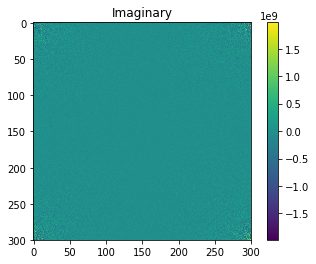

In [69]:
plt.imshow(np.imag(fft2D))
plt.colorbar()
plt.title("Imaginary")

Text(0.5,1,'Absolute')

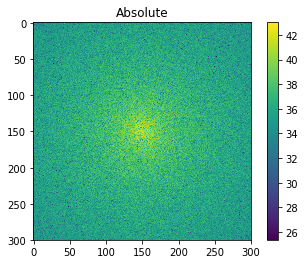

In [73]:
plt.imshow((np.log(np.abs(np.fft.fftshift(fft2D))**2)))
plt.colorbar()
plt.title("Absolute")